![](https://github.com/linkedin/greykite/raw/master/LOGO-C8.png)

LinkedIn releases a time-series forecasting library, [Greykite](https://github.com/linkedin/greykite), to simplify prediction for data scientists. The primary forecasting algorithm used in this library is Silverkite, which automates the forecasting. LinkedIn developed GrekKite to support its team make effective decisions based on the time-series forecasting models. As the library also helps interpret outputs, it can become a go-to tool for most time-series forecasting. LinkedIn also had, last year, released a Fairness Toolkit for explainability in machine learning. 

Over the years, LinkedIn has been using the Greykite library to provide sufficient infrastructure to handle peak traffic, set business targets, and optimize budget decisions.

![](https://analyticsdrift.com/wp-content/uploads/2021/05/LinkedIn-greykite-architecture-1024x481.png)



# Installation

In [ ]:
%matplotlib inline
!pip install -qqq greykite


Simple Forecast
===============

In [84]:
# !pip install -qqq pandas
import pandas as pd


df = pd.read_csv('/kaggle/input/electric-production/Electric_Production.csv')

df['DATE'] = df['DATE'].astype('datetime64[ns]')
df.rename(columns = {'DATE': 'ts', 'Value': 'y'}, inplace = True)
df = df.head(100)
df

,ts,y
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
95,1992-12-01,84.5159
96,1993-01-01,87.9464
97,1993-02-01,84.5561
98,1993-03-01,79.4747


In [85]:
from collections import defaultdict
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import plotly

from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster 
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results


Create a forecast
-----------------



In [86]:
# Specifies dataset information
metadata = MetadataParam(
     time_col="ts",  # name of the time column
     value_col="y",  # name of the value column
     freq="MS"  #"MS" for Montly at start date, "H" for hourly, "D" for daily, "W" for weekly, etc.
 )

forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df=df,
     config=ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=100,  # forecasts 100 steps ahead
         coverage=0.95,  # 95% prediction intervals
         metadata_param=metadata
    )
)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


The output of **run_forecast_config** is a dictionary that contains the future forecast, historical forecast performance, and the original timeseries.



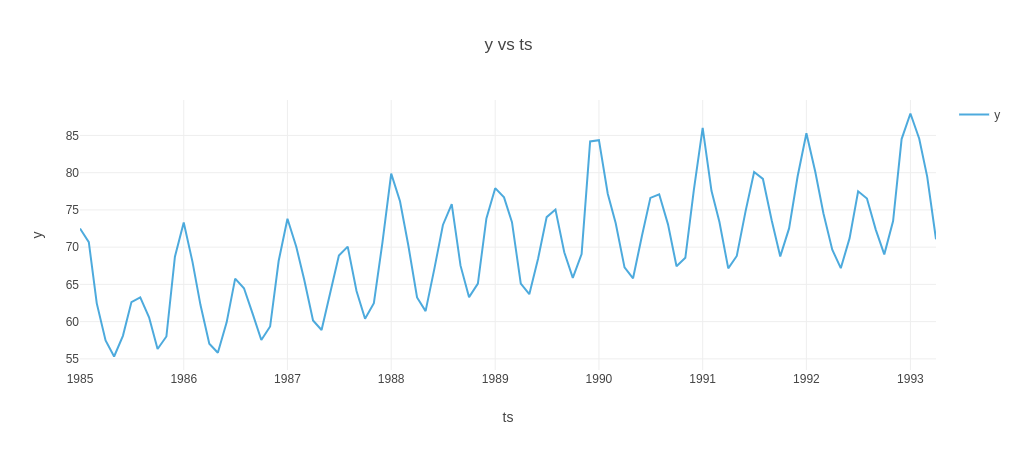

In [87]:
ts = result.timeseries
fig = ts.plot()
plotly.io.show(fig)

## Cross-validation

By default, run_forecast_config provides historical evaluation, so you can see how the forecast performs on past data. This is stored in grid_search (cross-validation splits) and backtest (holdout test set).

Let’s check the cross-validation results. By default, all metrics in ElementwiseEvaluationMetricEnum are computed on each CV train/test split. The configuration of CV evaluation metrics can be found at Evaluation Metric. Below, we show the Mean Absolute Percentage Error (MAPE) across splits 

(see [summarize_grid_search_results](https://linkedin.github.io/greykite/docs/0.1.0/html/pages/autodoc/doc.html#greykite.framework.utils.result_summary.summarize_grid_search_results) to control what to show and for details on the output columns).

In [88]:
 grid_search = result.grid_search
 cv_results = summarize_grid_search_results(
     grid_search=grid_search,
     decimals=2,
     # The below saves space in the printed output. Remove to show all available metrics and columns.
     cv_report_metrics=None,
     column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])
 # Transposes to save space in the printed output
 cv_results["params"] = cv_results["params"].astype(str)
 cv_results.set_index("params", drop=True, inplace=True)
 cv_results.transpose()

params,[]
rank_test_MAPE,1
mean_test_MAPE,4.35
split_test_MAPE,"(4.65, 4.05)"
mean_train_MAPE,3.43
split_train_MAPE,"(3.07, 3.79)"
mean_fit_time,7.41
mean_score_time,0.78


## Backtest
Let's plot the historical forecast on the holdout test set.
You can zoom in to see how it performed in any given period.



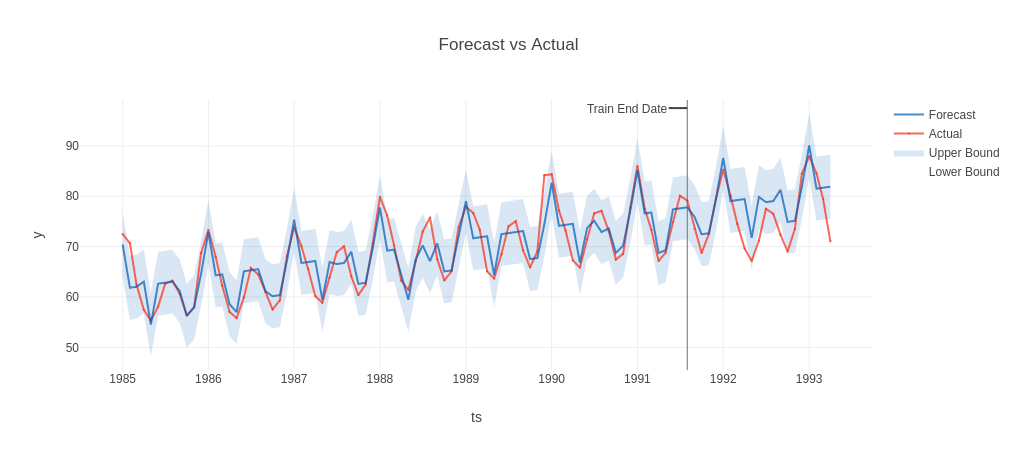

In [89]:
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

You can also check historical evaluation metrics (on the historical training/test set).


In [90]:
 backtest_eval = defaultdict(list)
 for metric, value in backtest.train_evaluation.items():
     backtest_eval[metric].append(value)
     backtest_eval[metric].append(backtest.test_evaluation[metric])
 metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
 metrics

,train,test
CORR,0.895824,0.767945
R2,0.801559,0.298319
MSE,10.3633,25.4429
RMSE,3.21921,5.04409
MAE,2.37149,3.93065
MedAE,1.61322,2.56083
MAPE,3.44801,5.38107
MedAPE,2.37733,3.2402
sMAPE,1.72269,2.57915
Q80,1.18575,0.990506


## Forecast
The **forecast** attribute contains the forecasted result. Just as for **backtest**, you can plot the result or see the evaluation metrics.

Let’s plot the forecast (trained on all data):

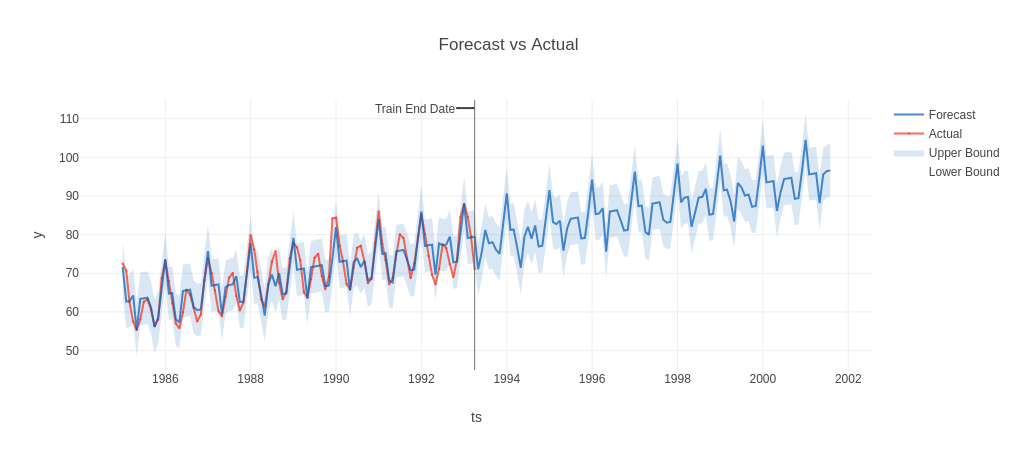

In [91]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

The forecasted values are available in df.



In [92]:
 forecast.df.head().round(2)

,ts,actual,forecast,forecast_lower,forecast_upper
0,1985-01-01,72.51,71.63,64.82,78.45
1,1985-02-01,70.67,62.68,55.87,69.50
2,1985-03-01,62.45,62.84,56.03,69.65
3,1985-04-01,57.47,64.24,57.43,71.05
4,1985-05-01,55.32,55.28,48.47,62.09


## Model Diagnostics
The component plot shows how your dataset’s trend, seasonality, and event / holiday patterns are handled in the model:

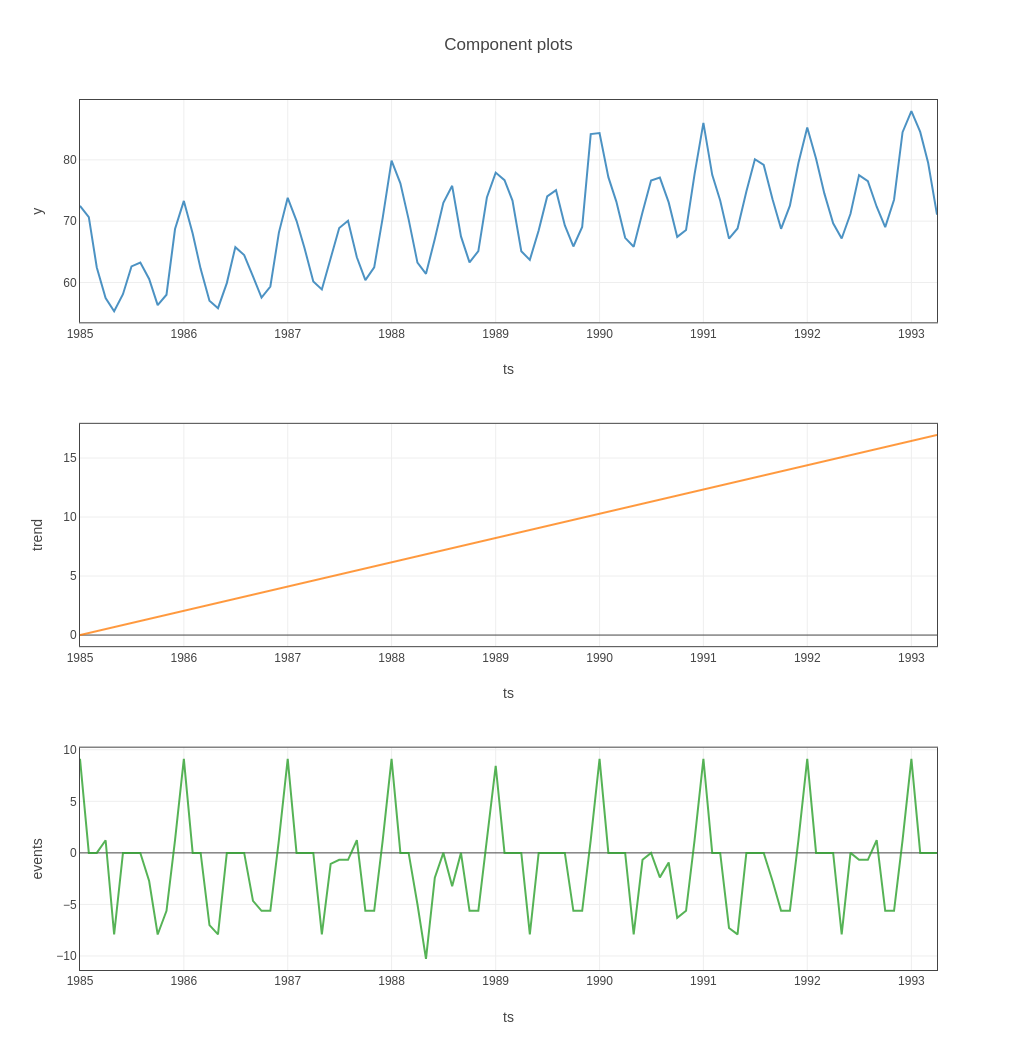

In [93]:
fig = forecast.plot_components()
plotly.io.show(fig)     # fig.show() if you are using "PROPHET" template

Model summary allows inspection of individual model terms. Check parameter estimates and their significance for insights on how the model works and what can be further improved.

In [94]:
 summary = result.model[-1].summary()  # -1 retrieves the estimator from the pipeline
 print(summary)

================================ Model Summary =================================

Number of observations: 100,   Number of features: 57
Method: Ridge regression
Number of nonzero features: 15
Regularization parameter: 0.1748

Residuals:
         Min           1Q       Median           3Q          Max
      -8.408       -1.505        -0.15        2.119        10.35

             Pred_col Estimate Std. Err Pr(>)_boot sig. code             95%CI
            Intercept    62.51   0.9147     <2e-16       ***    (60.65, 64.31)
  events_C...New Year       0.       0.      1.000                    (0., 0.)
  events_C...w Year-1       0.       0.      1.000                    (0., 0.)
  events_C...w Year-2       0.       0.      1.000                    (0., 0.)
  events_C...w Year+1       0.       0.      1.000                    (0., 0.)
  events_C...w Year+2       0.       0.      1.000                    (0., 0.)
 events_Christmas Day       0.       0.      1.000                    (0., 0.)
